In [7]:
from matplotlib import rcParams
import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline
import h5py as h5
from Corrfunc.mocks.DDrppi_mocks import DDrppi_mocks
from Corrfunc.utils import convert_rp_pi_counts_to_wp
from corr_func import *
import fitsio

from Corrfunc.theory.DD import DD
from Corrfunc.utils import convert_3d_counts_to_cf

import matplotlib
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}
from matplotlib import gridspec

matplotlib.rc('font', **font)

## Read RedMapper H5 file (1.9.8)

In [ ]:
# class ReadY3H5Files(object):
#     """Read Y3 H5 files and set up atributes """
#     def __init__(self, fname):
#         self.fname = fname
#     def get_redmapper(self):
#         f = h5.File(self.fname, 'r')
#         data = f['catalog/redmapper/lgt20']
#         self.redmapper_id = data['mem_match_id'][:]
#         self.lam = data['lambda_chisq'][:]
#         self.ra = data['ra'][:]
#         self.dec = data['dec'][:]
#         self.z = data['z_lambda'][:]
#         f.close()
#     def get_redmagic(self):
#         f = h5.File(self.fname, 'r')
#         data = f['catalog/redmagic/higherlum']
#         self.ra_rand = data['ra'][:]
#         self.dec_rand = data['dec'][:]

In [ ]:
# fname = 'buzzard-1.9.8_3y3a_run_redmapper_v6.4.22.h5'
# f = h5.File(fname, 'r')
# data = f['catalog/redmapper/lgt20']

# ra = data['ra'][:] 
# dec = data['dec'][:]
# z = data['z_lambda'][:]

# mask_0305 = [Z < 0.5 and Z > 0.3 for Z in z]
# RA_zlam = ra[mask_0305]
# DEC_zlam = dec[mask_0305]
# CZ_zlam = 299792. * z[mask_0305]

# print len(RA_zlam), len(DEC_zlam), len(CZ_zlam)

## Read Mock FITS file

In [ ]:
#catalog = buzzard_1.9.9_3y3a_rsshift_run_redmagic_highdens.fit
#randoms = buzzard_1.9.9_3y3a_rsshift_run_redmagic_highdens_randoms.fit

fname = 'buzzard_1.9.9_3y3a_rsshift_run_redmagic_highdens.fit'

d,h = fitsio.read(fname, header=True)
#print h

z_low = 0.3
z_high = 0.5

d_zred = z_cut(d, 'zredmagic', z_low, z_high)
RA_zred = d_zred['ra']
DEC_zred = d_zred['dec']
CZ_zred = 299792. * d_zred['zredmagic']

print len(d_zred)

d_zspec = z_cut(d, 'zspec', z_low, z_high)
RA_zspec = d_zspec['ra']
DEC_zspec = d_zspec['dec']
CZ_zspec = 299792. * d_zspec['zspec']

print len(d_zspec)

## Read Rand FITS file

In [ ]:
rname = 'buzzard_1.9.9_3y3a_rsshift_run_redmagic_highdens_randoms.fit'

d_rand, h_rand = fitsio.read(rname, header=True)
#print h_rand
#print d.dtype

d_rand = z_cut(d_rand, 'z', z_low, z_high)
RA_rand = d_rand['ra']
DEC_rand = d_rand['dec']
CZ_rand = 299792. * d_rand['z']

np.random.seed(200)
CZ_randzspec = np.random.choice(CZ_zspec, size=len(RA_rand), replace=True)
print len(RA_rand)

#plt.hist(CZ_rand, normed=True, bins=50) 

In [ ]:
plt.hist(CZ_rand, normed=True, bins=50, histtype='step', color='blue', label="CZ_rand")
plt.hist(CZ_randzspec, normed=True, bins=50, histtype='step', color='red', label='CZ_rand_zspec')
plt.hist(CZ_zspec, normed=True, bins=50, histtype='step', color='black', label="CZ_zspec")
plt.hist(CZ_zspec_noise, normed=True, bins=50, histtype='step', color='orange', label="CZ_zspec_noise")
plt.legend(loc='lower right')

## $\sigma_z$ vs z

In [ ]:
from scipy.stats import norm
from scipy.interpolate import interp1d

fig, ax = plt.subplots(3, figsize=(10,10))

width = 0.1
z_high_lim = 0.8
std_list = []
mu_list = []
z_spec_mean = []

fig.suptitle('$\sigma_z$ with redshift bin width ' + str(width),fontsize=20)

for z in np.arange(0, z_high_lim, width):
    z_min = z
    z_max = z_min + width
    d_zspec_cut = d[d['zspec'] > z_min]
    d_zspec_cut = d_zspec_cut[d_zspec_cut['zspec'] < z_max]
    diff = d_zspec_cut['zspec'] - d_zspec_cut['zredmagic']
    mu, std = norm.fit(diff)
    #compare if a distribution is gaussian or not
    #std = np.std(diff)
    std_list.append(std)
    mu_list.append(mu)
    z_spec_mean.append(np.mean(d_zspec_cut['zspec']))

ax[0].axhline(y=0,xmin=0,xmax=1,linestyle='--',color='black',linewidth=3)
ax[0].plot(z_spec_mean, std_list, marker='o', label='$\sigma_z$')
ax[0].plot(z_spec_mean, mu_list, marker='o', label='$\mu$')

z_linear = interp1d(z_spec_mean, std_list)
ax[1].plot(z_spec_mean, z_linear(z_spec_mean), label='$\sigma_z$ linear fit')

d_zred_cut = z_cut(d, 'zredmagic', 0, z_high_lim)
d_zspec_cut = z_cut(d, 'zspec', 0, z_high_lim)
ax[2].hist(d_zred_cut['zredmagic'], normed=1, bins=20, histtype = 'step', label="$z_\mathrm{redmagic}$", linewidth=2) 
ax[2].hist(d_zspec_cut['zspec'], normed=1, bins=20, histtype='step', label="$z_\mathrm{spec}$", linewidth=2)
ax[2].set_xlabel('$z_\mathrm{spec}$', fontsize=15)

for a in ax.flat:
    a.tick_params(axis='both', which='both', labelsize=15, width=1.2)
    a.legend(fontsize=15, framealpha=0.6, loc='upper left')

plt.savefig("sigma_z_" + str(width) + "_" + str(z_high_lim) + ".pdf",dpi=300,bbox_inches='tight')

In [ ]:
# Obtain zspec+noise (or zsepc_nor) from zspec within redshift range (0.1, 0.7)
d_0107 = z_cut(d, 'zspec', 0.1, 0.7)
zspec_0107 = d_0107['zspec']
ra_0107 = d_0107['ra']
dec_0107 = d_0107['dec']

sigma_list = z_linear(zspec_0107)
np.random.seed(200)
err_list = np.random.normal(0, sigma_list)
zspec_noise_0107 = [a + b for a,b in zip(zspec_0107, err_list)]
# Create a mask with condition 0.3 < zspec_noise < 0.5 
mask_0305 = [z < 0.5 and z > 0.3 for z in zspec_noise_0107]
# Convert zspec_noise, ra_noise, and dec_noise to array
zspec_noise_0107 = np.array(zspec_noise_0107)
ra_0107 = np.array(ra_0107)
dec_0107 = np.array(dec_0107)
# Filter galaxies between redshift 0.3 and 0.5
CZ_zspec_noise = 299792. * zspec_noise_0107[mask_0305]
RA_zspec_noise = ra_0107[mask_0305]
DEC_zspec_noise = dec_0107[mask_0305]
# Create CZ random for zspec_noise
np.random.seed(200)
CZ_randzspec_noise = np.random.choice(CZ_zspec_noise, size=len(RA_rand), replace=True)

## Read Redmapper Mock Halo FITS file

In [ ]:
fname_redmap = 'halo_file/halos_Chinchilla-3_Y3a.fit'

d_redmap, h_redmap = fitsio.read(fname_redmap, header=True)
print h_redmap

In [ ]:
d_zlam_zcut = z_cut(d_redmap, 'z_cosmo', z_low, z_high)
d_zlam = mass_cut(d_zlam_zcut, 'M200', 1E14, 1E16)
RA_zlam = d_zlam['ra']
DEC_zlam = d_zlam['dec']
CZ_zlam = 299792. * d_zlam['z_cosmo']

print len(d_zlam)
plt.hist(CZ_zlam/299792., normed=True, bins=50, histtype='step')

In [ ]:
Mass_zlam = d_zlam['M200']
plt.hist(np.log10(Mass_zlam), normed=True, bins=50, histtype='step')
plt.yscale('log')

## Read Redmapper Rand FITS file

In [ ]:
rname_redmap = 'halo_file/halos_rand.fit'

d_rand_redmap, h_rand_redmap = fitsio.read(rname_redmap, header=True)
print h_rand_redmap

In [ ]:
d_rand_redmap = z_cut(d_rand_redmap, 'z', z_low, z_high)[::100]

RA_rand_redmap = d_rand_redmap['ra']
DEC_rand_redmap = d_rand_redmap['dec']
CZ_rand_redmap = 299792. * d_rand_redmap['z']
print len(RA_rand_redmap)

#plt.hist(CZ_rand_redmap, normed=True, bins=50) 

## Calculate $\xi$  and $wp_{\mathrm{cg}}$ with LZ estimator

In [ ]:
# ND1 = float(len(RA_zred))
# ND2 = float(len(RA_zlam))
# NR1 = float(len(RA_rand))
# NR2 = float(len(RA_rand_redmap))
# ND1_zspec = float(len(RA_zspec_noise))
# print ND1, ND1_zspec

# # xi at some rp
# xi_rp_zred = []
# xi_rp_zspec = []

# wpcg_zred = []
# wpcg_zspec = []

# pimax_list_wpcg = [200,150,100,50]
# color = ['gray','black','darkgoldenrod','teal','red']
# nrpbins = 20

In [ ]:
# # Calculate wpcg using galaxy photo-z

# #pimax_list_wpcg = [100]
# pimax_list_wpcg = [150, 50]
# bins = np.logspace(np.log10(0.3), np.log10(30.0), nrpbins + 1)
# rp = (bins[0:-1] + bins[1:]) / 2.0
# for pimax in pimax_list_wpcg:
#     D1D2 = lz_cross(RA_zred, RA_zlam, DEC_zred, DEC_zlam, CZ_zred, CZ_zlam, nrpbins, pimax, 2, 8, 0.3, 30)
#     D1R2 = lz_cross(RA_zred, RA_rand_redmap, DEC_zred, DEC_rand_redmap, CZ_zred, CZ_rand_redmap, nrpbins, pimax, 2, 8, 0.3, 30)
#     D2R1 = lz_cross(RA_zlam, RA_rand, DEC_zlam, DEC_rand, CZ_zlam, CZ_rand, nrpbins, pimax, 2, 8, 0.3, 30)
#     R1R2 = lz_cross(RA_rand, RA_rand_redmap, DEC_rand, DEC_rand_redmap, CZ_rand, CZ_rand_redmap, nrpbins, pimax, 2, 8, 0.3, 30)

#     wp = convert_rp_pi_counts_to_wp(ND1, ND2, NR1, NR2, D1D2, D1R2, D2R1, R1R2, nrpbins, pimax,
#                                 dpi=1.0, estimator='LS')
#     wpcg_zred.append(wp)
#     np.savetxt("wpcg_zred_halo_" + str(pimax) + ".txt", np.transpose(np.array([rp, wp])))
#     np.savetxt("wpcg_zred_wp_halo_" + str(pimax) + ".txt", wp)
#     np.savetxt("wpcg_zred_D1D2_halo_" + str(pimax) + ".txt", D1D2)
#     np.savetxt("wpcg_zred_D1R2_halo_" + str(pimax) + ".txt", D1R2)
#     np.savetxt("wpcg_zred_D2R1_halo_" + str(pimax) + ".txt", D2R1)
#     np.savetxt("wpcg_zred_R1R2_halo_" + str(pimax) + ".txt", R1R2)


# # Calculate wpcg using galaxy spec-z+noise
# for pimax in pimax_list_wpcg:
#     D1D2 = lz_cross(RA_zspec_noise, RA_zlam, DEC_zspec_noise, DEC_zlam, CZ_zspec_noise, CZ_zlam, nrpbins, pimax, 2, 8, 0.3, 30)
#     D1R2 = lz_cross(RA_zspec_noise, RA_rand_redmap, DEC_zspec_noise, DEC_rand_redmap, CZ_zspec_noise, CZ_rand_redmap, 
#                     nrpbins, pimax, 2, 8, 0.3, 30)
#     D2R1 = lz_cross(RA_zlam, RA_rand, DEC_zlam, DEC_rand, CZ_zlam, CZ_randzspec_noise, nrpbins, pimax, 2, 8, 0.3, 30)
#     R1R2 = lz_cross(RA_rand, RA_rand_redmap, DEC_rand, DEC_rand_redmap, CZ_randzspec_noise, CZ_rand_redmap, 
#                     nrpbins, pimax, 2, 8, 0.3, 30)
    
#     wp = convert_rp_pi_counts_to_wp(ND1_zspec, ND2, NR1, NR2, D1D2, D1R2, D2R1, R1R2, nrpbins, pimax,
#                                 dpi=1.0, estimator='LS')
#     wpcg_zspec.append(wp)
#     np.savetxt("wpcg_zspec_halo_" + str(pimax) + ".txt", np.transpose(np.array([rp, wp])))

In [ ]:
# # Calculate wpcg using galaxy spec-z and wang's model
# pimax_list_wpcg = [100]
# #pimax_list_wpcg = [150, 50]
# nrpbins = 100
# bins = np.logspace(np.log10(0.1), np.log10(300.0), nrpbins + 1)
# rp_300 = (bins[0:-1] + bins[1:]) / 2.0
# for pimax in pimax_list_wpcg:
#     D1D2 = lz_cross(RA_zspec, RA_zlam, DEC_zspec, DEC_zlam, CZ_zspec, CZ_zlam, nrpbins, pimax, 2, 8, 0.1, 300)
#     D1R2 = lz_cross(RA_zspec, RA_rand_redmap, DEC_zspec, DEC_rand_redmap, CZ_zspec, CZ_rand_redmap, 
#                     nrpbins, pimax, 2, 8, 0.1, 300)
#     D2R1 = lz_cross(RA_zlam, RA_rand, DEC_zlam, DEC_rand, CZ_zlam, CZ_randzspec, nrpbins, pimax, 2, 8, 0.1, 300)
#     R1R2 = lz_cross(RA_rand, RA_rand_redmap, DEC_rand, DEC_rand_redmap, CZ_randzspec, CZ_rand_redmap, 
#                     nrpbins, pimax, 2, 8, 0.1, 300)
    
#     wp = convert_rp_pi_counts_to_wp(ND1_zspec, ND2, NR1, NR2, D1D2, D1R2, D2R1, R1R2, nrpbins, pimax,
#                                 dpi=1.0, estimator='LS')
#     wpcg_zspec.append(wp)
#     np.savetxt("wpcg_zspec_300_halo_" + str(pimax) + ".txt", np.transpose(np.array([rp_300, wp])))

In [ ]:
# rp_zspec_300 = np.loadtxt("wpcg_zspec_300_halo_100.txt")[:,0]
# wpcg_zspec_300 = np.loadtxt("wpcg_zspec_300_halo_100.txt")[:,1]

# rp_zspec_50 = np.loadtxt("wpcg_zspec_halo_50.txt")[:,0]
# wpcg_zspec_50 = np.loadtxt("wpcg_zspec_halo_50.txt")[:,1]

# rp_zspec_150 = np.loadtxt("wpcg_zspec_halo_150.txt")[:,0]
# wpcg_zspec_150 = np.loadtxt("wpcg_zspec_halo_150.txt")[:,1]

# rp_zspec_100 = np.loadtxt("wpcg_zspec_halo_100.txt")[:,0]
# wpcg_zspec_100 = np.loadtxt("wpcg_zspec_halo_100.txt")[:,1]

# rp_zred_50 = np.loadtxt("wpcg_zred_halo_50.txt")[:,0]
# wpcg_zred_50 = np.loadtxt("wpcg_zred_halo_50.txt")[:,1]

# rp_zred_150 = np.loadtxt("wpcg_zred_halo_150.txt")[:,0]
# wpcg_zred_150 = np.loadtxt("wpcg_zred_halo_150.txt")[:,1]

# rp_zred_100 = np.loadtxt("wpcg_zred_halo_100.txt")[:,0]
# wpcg_zred_100 = np.loadtxt("wpcg_zred_halo_100.txt")[:,1]

In [ ]:
# # Calculate xi from wp using Inv Abel using zspec, running slowly, do not need to rerun
# r_zspec_inv_abel, xi_zspec_inv_abel = xi_inv_abel(rp_zspec_300, wpcg_zspec_300, 0.15, 270)
# np.savetxt("wpcg_zspec_xi_inv_abel_halo" + ".txt", np.transpose(np.array([r_zspec_inv_abel, xi_zspec_inv_abel])))

In [ ]:
# # Calculate wpcg from Inv Abel using zspec and wang's model
# r_zspec_inv_abel = np.loadtxt("wpcg_zspec_xi_inv_abel_halo.txt")[:,0]
# xi_zspec_inv_abel = np.loadtxt("wpcg_zspec_xi_inv_abel_halo.txt")[:,1]
# model_zspec_inv_abel = xi_r_interpolate(r_zspec_inv_abel, xi_zspec_inv_abel)
# rp_wang, pi_wang, xi_wang_100, wpcg_wang_100, f = xi_matrix_model(model_zspec_inv_abel, 20, 100, 1.0)

In [ ]:
# wpcg_zred_30 = np.loadtxt("wpcg_zred_wp_halo_100.txt")
# print(len(wpcg_zred_30))
# print(len(wpcg_wang))

In [ ]:
# rp_zspec_300_150 = np.loadtxt("wpcg_zspec_300_halo_150.txt")[:,0]
# wpcg_zspec_300_150 = np.loadtxt("wpcg_zspec_300_halo_150.txt")[:,1]

In [ ]:
# # Calculate xi from wp using Inv Abel using zspec, running slowly, do not need to rerun
# r_zspec_inv_abel, xi_zspec_inv_abel = xi_inv_abel(rp_zspec_300_150, wpcg_zspec_300_150, 0.15, 270)
# np.savetxt("wpcg_zspec_xi_inv_abel_150_halo" + ".txt", np.transpose(np.array([r_zspec_inv_abel, xi_zspec_inv_abel])))

In [ ]:
# # Calculate wpcg from Inv Abel using zspec and wang's model
# r_zspec_inv_abel = np.loadtxt("wpcg_zspec_xi_inv_abel_150_halo.txt")[:,0]
# xi_zspec_inv_abel = np.loadtxt("wpcg_zspec_xi_inv_abel_150_halo.txt")[:,1]
# model_zspec_inv_abel_150 = xi_r_interpolate(r_zspec_inv_abel, xi_zspec_inv_abel)
# rp_wang_150, pi_wang_150, xi_wang_150, wpcg_wang_150, f_150 = xi_matrix_model(model_zspec_inv_abel_150, 20, 150, 1.0)

In [ ]:
# rp_zspec_300_50 = np.loadtxt("wpcg_zspec_300_halo_50.txt")[:,0]
# wpcg_zspec_300_50 = np.loadtxt("wpcg_zspec_300_halo_50.txt")[:,1]

In [ ]:
# # Calculate xi from wp using Inv Abel using zspec, running slowly, do not need to rerun
# r_zspec_inv_abel, xi_zspec_inv_abel = xi_inv_abel(rp_zspec_300_50, wpcg_zspec_300_50, 0.15, 270)
# np.savetxt("wpcg_zspec_xi_inv_abel_50_halo" + ".txt", np.transpose(np.array([r_zspec_inv_abel, xi_zspec_inv_abel])))

In [ ]:
# # Calculate wpcg from Inv Abel using zspec and wang's model
# r_zspec_inv_abel = np.loadtxt("wpcg_zspec_xi_inv_abel_50_halo.txt")[:,0]
# xi_zspec_inv_abel = np.loadtxt("wpcg_zspec_xi_inv_abel_50_halo.txt")[:,1]
# model_zspec_inv_abel_50 = xi_r_interpolate(r_zspec_inv_abel, xi_zspec_inv_abel)
# rp_wang_50, pi_wang_50, xi_wang_50, wpcg_wang_50, f_50 = xi_matrix_model(model_zspec_inv_abel_50, 20, 50, 1.0)

In [ ]:
# print len(rp), len(wpcg_zred_150)

In [ ]:
# # Plot wpcg vs rp
# fig = plt.figure()
# # set height ratios for sublots
# gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# nrpbins = 20
# bins = np.logspace(np.log10(0.3), np.log10(30.0), nrpbins + 1)
# rp = (bins[0:-1] + bins[1:]) / 2.0
# # the fisrt subplot
# ax0 = plt.subplot(gs[0])
# # log scale for axis Y of the first subplot
# ax0.set_yscale("log")
# ax0.set_xscale("log")
# ax0.set_ylabel("w$_{p,\mathrm{cg}}$")
# line2, = ax0.plot(rp, wpcg_zred_50, color='black', linestyle=':')
# line4, = ax0.plot(rp, wpcg_zspec_50, color='grey', linestyle='solid')
# line7, = ax0.plot(rp_wang, wpcg_wang_50, color='green', linestyle='-.')

# #the second subplot
# # shared axis X
# ax1 = plt.subplot(gs[1], sharex = ax0)
# line5, = ax1.plot(rp, [m/n for m, n in zip(wpcg_zspec_50, wpcg_zred_50)], color='grey', linestyle='solid')
# line6, = ax1.plot(rp, [m/n for m, n in zip(wpcg_wang_50, wpcg_zred_50)], color='green', linestyle='-.')
# plt.setp(ax0.get_xticklabels(), visible=False)
# ax1.set_xlabel("rp ($h^{-1}$Mpc)")
# # remove last tick label for the second subplot
# yticks = ax1.yaxis.get_major_ticks()
# yticks[-1].label1.set_visible(False)

# # put legend on first subplot
# ax0.legend((line2, line4, line7), ('zred_DDrppi_mock', 
#                                           'zspec_noise', 'zspec_inv_abel_wang'), loc='lower left', fontsize=10)

# # remove vertical gap between subplots
# plt.subplots_adjust(hspace=.0)
# plt.show()
# plt.savefig("redmapper_wpcg_halo.pdf",dpi=300,bbox_inches='tight')

# Calculate and Plot xihg and the ratio with ximm_Andres

In [ ]:
ND1 = float(len(RA_zred))
ND2 = float(len(RA_zlam))
NR1 = float(len(RA_rand))
NR2 = float(len(RA_rand_redmap))
ND1_zspec = float(len(RA_zspec_noise))
print ND1, ND1_zspec, ND2

pimax_list_wpcg = [200,150,100,50]
color = ['gray','black','darkgoldenrod','teal','red']

In [ ]:
# Calculate wphg using galaxy spec-z and wang's model
pimax_list_wpcg = [100]
#pimax_list_wpcg = [150, 50]
nrpbins = 15
bins = np.logspace(np.log10(0.1), np.log10(300.0), nrpbins + 1)
rp_300 = (bins[0:-1] + bins[1:]) / 2.0
for pimax in pimax_list_wpcg:
    D1D2 = lz_cross(RA_zspec, RA_zlam, DEC_zspec, DEC_zlam, CZ_zspec, CZ_zlam, nrpbins, pimax, 2, 8, 0.1, 300)
    D1R2 = lz_cross(RA_zspec, RA_rand_redmap, DEC_zspec, DEC_rand_redmap, CZ_zspec, CZ_rand_redmap, 
                    nrpbins, pimax, 2, 8, 0.1, 300)
    D2R1 = lz_cross(RA_zlam, RA_rand, DEC_zlam, DEC_rand, CZ_zlam, CZ_randzspec, nrpbins, pimax, 2, 8, 0.1, 300)
    R1R2 = lz_cross(RA_rand, RA_rand_redmap, DEC_rand, DEC_rand_redmap, CZ_randzspec, CZ_rand_redmap, 
                    nrpbins, pimax, 2, 8, 0.1, 300)
    
    wp = convert_rp_pi_counts_to_wp(ND1_zspec, ND2, NR1, NR2, D1D2, D1R2, D2R1, R1R2, nrpbins, pimax,
                                dpi=1.0, estimator='LS')
    np.savetxt("wphg_zspec_300_halo_mass_cut_" + str(pimax) + ".txt", np.transpose(np.array([rp_300, wp])))

In [2]:
r_ximm_min = np.loadtxt("ximm_Andres.txt")[1:33,0]
r_ximm_max = np.loadtxt("ximm_Andres.txt")[1:33,1]
r_ximm = (r_ximm_min + r_ximm_max) / 2
ximm = np.loadtxt("ximm_Andres.txt")[1:33,3]

In [4]:
# (for plotting) Calculate xihg from wp using Inv Abel using zspec, running slowly, do not need to rerun
rp_zspec_300 = np.loadtxt("wphg_zspec_300_halo_mass_cut_100.txt")[:,0]
wphg_zspec_300 = np.loadtxt("wphg_zspec_300_halo_mass_cut_100.txt")[:,1]
r_zspec_inv_abel, xi_zspec_inv_abel = xi_inv_abel(rp_zspec_300, wphg_zspec_300, 1.5, 130, 40)
np.savetxt("xihg_zspec_inv_abel_mass_cut" + ".txt", np.transpose(np.array([r_zspec_inv_abel, xi_zspec_inv_abel])))

In [5]:
r_zspec_inv_abel = np.loadtxt("xihg_zspec_inv_abel_mass_cut.txt")[1:33,0]
xi_zspec_inv_abel = np.loadtxt("xihg_zspec_inv_abel_mass_cut.txt")[1:33,1]

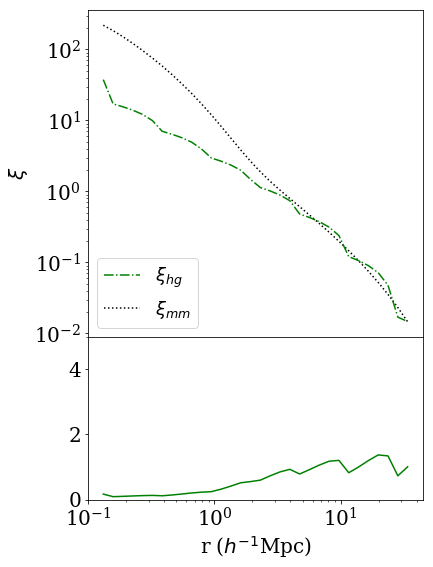

In [8]:
# Plot xicg vs rp
fig = plt.figure(figsize=(6, 9))
# set height ratios for sublots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# the fisrt subplot
ax0 = plt.subplot(gs[0])
# log scale for axis Y of the first subplot
ax0.set_yscale("log")
ax0.set_xscale("log")
ax0.set_ylabel("$\\xi$")
line1, = ax0.plot(r_ximm, ximm, color='black', linestyle=':')
line2, = ax0.plot(r_ximm, xi_zspec_inv_abel, color='green', linestyle='-.')

#the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
line3, = ax1.plot(r_ximm, [m/n for m, n in zip(xi_zspec_inv_abel, ximm)], color='green', linestyle='solid')
plt.setp(ax0.get_xticklabels(), visible=False)
ax1.set_xlabel("r ($h^{-1}$Mpc)")
ax1.set_ylim(0,5)
# remove last tick label for the second subplot
yticks = ax1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)

# put legend on first subplot
ax0.legend((line2, line1), ('$\\xi_{hg}$', '$\\xi_{mm}$'), loc='lower left', fontsize=18)

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.savefig("xihg_vs_ximm.pdf",dpi=300,bbox_inches='tight')
plt.show()

# Calculate and Plot xihh and the ratio with ximm_Andres

In [ ]:
ND1 = float(len(RA_zred))
ND2 = float(len(RA_zlam))
NR1 = float(len(RA_rand))
NR2 = float(len(RA_rand_redmap))
ND1_zspec = float(len(RA_zspec_noise))

pimax_list_wpcg = [100]
#nrpbins = 100 # 100 could be too large for halo-halo autocorrelation
nrpbins = 15 # try 15 first
bins = np.logspace(np.log10(0.1), np.log10(300.0), nrpbins + 1)
rp_300 = (bins[0:-1] + bins[1:]) / 2.0
for pimax in pimax_list_wpcg:
    D1D2 = lz_cross(RA_zlam, RA_zlam, DEC_zlam, DEC_zlam, CZ_zlam, CZ_zlam, nrpbins, pimax, 2, 8, 0.1, 300)
    D1R2 = lz_cross(RA_zlam, RA_rand_redmap, DEC_zlam, DEC_rand_redmap, CZ_zlam, CZ_rand_redmap, nrpbins, pimax, 2, 8, 0.1, 300)
    D2R1 = lz_cross(RA_zlam, RA_rand_redmap, DEC_zlam, DEC_rand_redmap, CZ_zlam, CZ_rand_redmap, nrpbins, pimax, 2, 8, 0.1, 300)
    R1R2 = lz_cross(RA_rand_redmap, RA_rand_redmap, DEC_rand_redmap, DEC_rand_redmap, CZ_rand_redmap, CZ_rand_redmap, 
                    nrpbins, pimax, 2, 8, 0.1, 300)
    
    wp = convert_rp_pi_counts_to_wp(ND1_zspec, ND2, NR1, NR2, D1D2, D1R2, D2R1, R1R2, nrpbins, pimax,
                                dpi=1.0, estimator='LS')
    np.savetxt("wphh_zspec_300_halo_mass_cut" + str(pimax) + ".txt", np.transpose(np.array([rp_300, wp])))

In [ ]:
r_ximm_min = np.loadtxt("ximm_Andres.txt")[1:33,0]
r_ximm_max = np.loadtxt("ximm_Andres.txt")[1:33,1]
r_ximm = (r_ximm_min + r_ximm_max) / 2
ximm = np.loadtxt("ximm_Andres.txt")[1:33,3]

In [ ]:
# (for plotting) Calculate xihh from wp using Inv Abel using zspec, running slowly, do not need to rerun
rp_zspec_300 = np.loadtxt("wphh_zspec_300_halo_mass_cut100.txt")[:,0]
wphh_zspec_300 = np.loadtxt("wphh_zspec_300_halo_mass_cut100.txt")[:,1]
r_zspec_inv_abel, xi_zspec_inv_abel = xi_inv_abel(rp_zspec_300, wphh_zspec_300, 1.5, 130, 40)
np.savetxt("xihh_zspec_inv_abel_mass_cut" + ".txt", np.transpose(np.array([r_zspec_inv_abel, xi_zspec_inv_abel])))

In [ ]:
r_zspec_inv_abel = np.loadtxt("xihh_zspec_inv_abel_mass_cut.txt")[1:33,0]
xi_zspec_inv_abel = np.loadtxt("xihh_zspec_inv_abel_mass_cut.txt")[1:33,1]

In [ ]:
# Plot xicg vs rp
fig = plt.figure(figsize=(6, 9))
# set height ratios for sublots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# the fisrt subplot
ax0 = plt.subplot(gs[0])
# log scale for axis Y of the first subplot
ax0.set_yscale("log")
ax0.set_xscale("log")
ax0.set_ylabel("$\\xi$")
line1, = ax0.plot(r_ximm, ximm, color='black', linestyle=':')
line2, = ax0.plot(r_ximm, xi_zspec_inv_abel, color='green', linestyle='-.')

#the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
line3, = ax1.plot(r_ximm, [m/n for m, n in zip(xi_zspec_inv_abel, ximm)], color='green', linestyle='solid')
plt.setp(ax0.get_xticklabels(), visible=False)
ax1.set_xlabel("r ($h^{-1}$Mpc)")
# remove last tick label for the second subplot
yticks = ax1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)

# put legend on first subplot
ax0.legend((line2, line1), ('$\\xi_{hh}$', '$\\xi_{mm}$'), loc='lower left', fontsize=18)

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.savefig("xihh_vs_ximm.pdf",dpi=300,bbox_inches='tight')
plt.show()